In [41]:
from matplotlib.dates import date2num, num2date
from matplotlib.colors import ListedColormap
from matplotlib.ticker import MaxNLocator
from matplotlib import dates as mdates
from matplotlib.patches import Patch
from matplotlib import pyplot as plt
from matplotlib import ticker

import pandas as pd
import numpy as np


#%% Plot Tong's default setting
SMALL_SIZE  = 22
MEDIUM_SIZE = 22
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE, family='sans-serif', serif='Arial')          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels"
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('text')

from matplotlib.ticker import MaxNLocator
my_locator = MaxNLocator(6)

'''
colorWheel =['#329932', '#ff6961', 'b', '#6a3d9a', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00',
            '#cab2d6', '#6a3d9a', '#ffff99', '#b15928', '#67001f', '#b2182b', '#d6604d',
            '#f4a582', '#fddbc7', '#f7f7f7', '#d1e5f0', '#92c5de', '#4393c3', '#2166ac', '#053061']
dashesStyles = [[3,1],
            [1000,1],
            [2,1,10,1],
            [4, 1, 1, 1, 1, 1]]
'''

NUMOFAGENTS = 46850
color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
color_list2 = ['#070707', '#ff3b3b'] # ['#81b8df', '#fe817d']
color_list3 = ['#4d85bd', '#f7913d', '#59a95a'] # ['#d22026', '#385889', '#7fa5b7']
color_list4 = ['#2d3063', '#6dab7a', '#d4357a', '#e3ab12']
color_list5 = ['#015699', '#fabf0f', '#f3774a', '#5fc5c9', '#15ab30']#['#015699', '#fabf0f', '#f3774a', '#5fc5c9', '#4f596d']

def figure_size_setting(WIDTH):
    #WIDTH = 700.0  # the number latex spits out
    FACTOR = 0.8  # the fraction of the width you'd like the figure to occupy
    fig_width_pt  = WIDTH * FACTOR
    inches_per_pt = 1.0 / 72.27
    golden_ratio  = (np.sqrt(5) - 1.0) / 2.0      # because it looks good
    fig_width_in  = fig_width_pt * inches_per_pt  # figure width in inches
    fig_height_in = fig_width_in * golden_ratio   # figure height in inches
    fig_dims    = [fig_width_in, fig_height_in]   # fig dims as a list
    return fig_dims


def format_axis(ax, week=True):
    ax.tick_params(which='both', axis='x', labelrotation=90)
    ax.xaxis.set_major_locator(mdates.YearLocator() )
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)


def create_df_response(samples, time, date_init ='2020-03-06',  quantiles = [50, 80, 95], forecast_horizon=27, dates=None, use_future=False):
    """[summary]

    Args:
        samples ([type]): [description]
        time ([type]): [description]
        date_init (str, optional): [description]. Defaults to '2020-03-06'.
        forecast_horizon (int, optional): [description]. Defaults to 27.
        use_future (bool, optional): [description]. Defaults to False.

    Returns:
        [type]: [description]
    """
    if dates is not None:
        dates_fitted = dates
    else:
        dates_fitted   = pd.date_range(start=pd.to_datetime(date_init), periods=time)
        dates_forecast = pd.date_range(start=dates_fitted[-1]+datetime.timedelta(1), periods=forecast_horizon)

    dates = list(dates_fitted)
    types = ['estimate']*len(dates_fitted)
    if use_future:
        dates += list(dates_forecast)
        types  += ['forecast']*len(dates_forecast)

    results_df = pd.DataFrame(samples.T)
    df_response = pd.DataFrame(index=dates)
    # Calculate key statistics
    df_response['mean']        = results_df.mean(axis=1).values
    df_response['median']      = results_df.median(axis=1).values
    df_response['std']         = results_df.std(axis=1).values

    for quant in quantiles:
        low_q  = ((100-quant)/2)/100
        high_q = 1-low_q

        df_response[f'low_{quant}']  = results_df.quantile(q=low_q, axis=1).values
        df_response[f'high_{quant}'] = results_df.quantile(q=high_q, axis=1).values

    df_response['type']        =  types
    df_response.index.name = 'date'

    return df_response

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import time

import jax.random as jrandom
import jax.numpy as jnp
import jax.nn as jnn
import jax

import equinox as eqx  # https://github.com/patrick-kidger/equinox
import diffrax
import optax  # https://github.com/deepmind/optax



In [2]:
class Func(eqx.Module):
    mlp: eqx.nn.MLP

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.mlp = eqx.nn.MLP(
            in_size=data_size,
            out_size=data_size,
            width_size=width_size,
            depth=depth,
            activation=jnn.softplus,
            key=key,
        )

    def __call__(self, t, y, args):
        return self.mlp(y)

In [3]:
class NeuralODE(eqx.Module):
    func: Func

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.func = Func(data_size, width_size, depth, key=key)

    def __call__(self, ts, y0):
        solution = diffrax.diffeqsolve(
            diffrax.ODETerm(self.func),
            diffrax.Tsit5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1] - ts[0],
            y0=y0,
            stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            saveat=diffrax.SaveAt(ts=ts),
        )
        return solution.ys

In [4]:
def _get_data(ts, *, key):
    y0 = jrandom.uniform(key, (2,), minval=-0.6, maxval=1)

    def f(t, y, args):
        x = y / (1 + y)

        return jnp.stack([x[1], -x[0]], axis=-1)

    solver = diffrax.Tsit5()
    dt0 = 0.1
    saveat = diffrax.SaveAt(ts=ts) # frequency

    # solution of the ode
    sol    = diffrax.diffeqsolve(diffrax.ODETerm(f), solver, ts[0], ts[-1], dt0, y0, saveat=saveat)
    ys = sol.ys
    return ys


def get_data(dataset_size, *, key):
    ts  = jnp.linspace(0, 10, 100)
    key = jrandom.split(key, dataset_size)
    ys  = jax.vmap(lambda key: _get_data(ts, key=key))(key)
    return ts, ys

In [5]:
def dataloader(arrays, batch_size, *, key):
    dataset_size = arrays[0].shape[0]
    assert all(array.shape[0] == dataset_size for array in arrays)
    indices = jnp.arange(dataset_size)
    while True:
        perm = jrandom.permutation(key, indices)
        (key,) = jrandom.split(key, 1)
        start = 0
        end = batch_size
        while end < dataset_size:
            batch_perm = perm[start:end]
            yield tuple(array[batch_perm] for array in arrays)
            start = end
            end = start + batch_size

In [9]:
def main(
    dataset_size=256,
    batch_size=32,
    lr_strategy=(3e-3, 3e-3),
    steps_strategy=(500, 500),
    length_strategy=(0.1, 1),
    width_size=64,
    depth=2,
    seed=5678,
    plot=True,
    print_every=100,
):
    key = jrandom.PRNGKey(seed)
    data_key, model_key, loader_key = jrandom.split(key, 3)

    ts, ys = get_data(dataset_size, key=data_key)
    _, length_size, data_size = ys.shape

    model = NeuralODE(data_size, width_size, depth, key=model_key)

    # Training loop like normal.
    #
    # Only thing to notice is that up until step 500 we train on only the first 10% of
    # each time series. This is a standard trick to avoid getting caught in a local
    # minimum.

    @eqx.filter_value_and_grad
    def grad_loss(model, ti, yi):
        y_pred = jax.vmap(model, in_axes=(None, 0))(ti, yi[:, 0])
        return jnp.mean((yi - y_pred) ** 2)

    @eqx.filter_jit
    def make_step(ti, yi, model, opt_state):
        loss, grads = grad_loss(model, ti, yi)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state

    for lr, steps, length in zip(lr_strategy, steps_strategy, length_strategy):
        optim = optax.adabelief(lr)
        opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))
        _ts = ts[: int(length_size * length)]
        _ys = ys[:, : int(length_size * length)]
        for step, (yi,) in zip(
            range(steps), dataloader((_ys,), batch_size, key=loader_key)
        ):
            start = time.time()
            loss, model, opt_state = make_step(_ts, yi, model, opt_state)
            end = time.time()
            if (step % print_every) == 0 or step == steps - 1:
                print("Step: {}, Loss: {:0.5f}, Computation time: {}".format(step, loss, end-start))

    if plot:
        plt.plot(ts, ys[0, :, 0], c="dodgerblue", label="Real")
        plt.plot(ts, ys[0, :, 1], c="dodgerblue"

        model_y = model(ts, ys[0, 0])
        plt.plot(ts, model_y[:, 0], c="crimson", label="Model")
        plt.plot(ts, model_y[:, 1], c="crimson")
        plt.legend()
        plt.tight_layout()
        plt.savefig("neural_ode.png")
        plt.show()

    return ts, ys, model

In [10]:
ts, ys, model = main(plot=False)


Step: 0, Loss: 0.16657, Computation time: 26.712522983551025
Step: 100, Loss: 0.01116, Computation time: 0.021194934844970703
Step: 200, Loss: 0.00648, Computation time: 0.022764921188354492
Step: 300, Loss: 0.00138, Computation time: 0.022404193878173828
Step: 400, Loss: 0.00107, Computation time: 0.023756980895996094
Step: 499, Loss: 0.00080, Computation time: 0.02391505241394043
Step: 0, Loss: 0.02835, Computation time: 23.104035139083862
Step: 100, Loss: 0.00542, Computation time: 0.0605471134185791
Step: 200, Loss: 0.00436, Computation time: 0.06884407997131348
Step: 300, Loss: 0.00180, Computation time: 0.06681609153747559
Step: 400, Loss: 0.00171, Computation time: 0.048029184341430664
Step: 499, Loss: 0.00118, Computation time: 0.060903072357177734


In [11]:
simulation = model(ts, ys[0, 0])


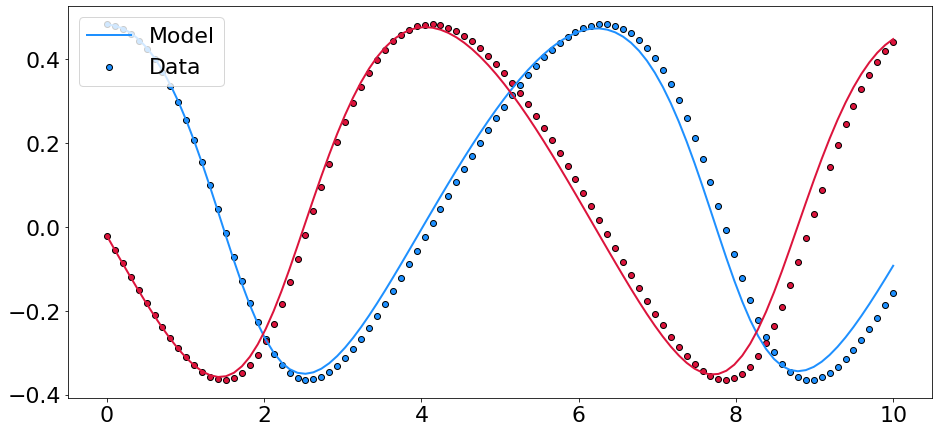

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(15.5, 7.2))


ax.plot(ts, simulation[:, 0].T, color="dodgerblue", lw=2, label="Model")#, facecolor="red", edgecolor="black")
ax.plot(ts, simulation[:, 1].T, color="crimson", lw=2)#, facecolor="red", edgecolor="black")


ax.scatter(ts, ys[0, :, 0].T, edgecolor="k", facecolor="dodgerblue", label="Data")#, facecolor="red", edgecolor="black")
ax.scatter(ts, ys[0, :, 1].T, edgecolor="k", facecolor="crimson")#, facecolor="red", edgecolor="black")

ax.legend(loc="upper left")